In [1]:
# Install latest dev build of pypulseq
!pip install git+https://github.com/imr-framework/pypulseq.git@master

  Cloning https://github.com/imr-framework/pypulseq.git (to revision master) to /tmp/pip-req-build-401q4wba
  Running command git clone -q https://github.com/imr-framework/pypulseq.git /tmp/pip-req-build-401q4wba
  Created wheel for pypulseq: filename=pypulseq-1.2.0.post3-cp36-none-any.whl size=72207 sha256=eea2fbfd45e708c1912098c6ebf7107f2de4a22e370ecb5ca1b1607f44e7ac6e
  Stored in directory: /tmp/pip-ephem-wheel-cache-vo27aa7n/wheels/26/11/3a/72a41349df5d935cb208edcf473d3963f649d788a439cd179a
Successfully built pypulseq


In [3]:
from math import pi

import numpy as np

from pypulseq.Sequence.sequence import Sequence
from pypulseq.calc_duration import calc_duration
from pypulseq.make_adc import make_adc
from pypulseq.make_delay import make_delay
from pypulseq.make_sinc_pulse import make_sinc_pulse
from pypulseq.make_trap_pulse import make_trapezoid
from pypulseq.make_extended_trapezoid import make_extended_trapezoid
from pypulseq.calc_rf_center import calc_rf_center
from pypulseq.opts import Opts

## **USER INPUTS**
### **VALID ONLY IF MODE IS SET TO `CUSTOM`**
Set up parameters typically found on the user interface of the scanner computer console.

1. Angle values need to be entered in **degrees** (for example - RF flip angle)
2. Time values need to be entered in **milliseconds** (for example - TE)
3. Distance values need to be entered in **millimeteres** (for example - slice thickness)

In [4]:
# =========
# INTERLEAVED WITH IR
# GT, 07/31/20
# =========
def irse_interleaved_split_gradient(fov:float, n_slices:int, rf_flip:int, slice_thickness:float, 
                   Nx:int, Ny:int, TE:float, TR:float, TI:float, enc='xyz', slice_locations=None):
    # =========
    # SYSTEM LIMITS
    # =========
    # Set the hardware limits and initialize sequence object
    dG = 250e-6 # Fixed ramp time for all gradients
    system = Opts(max_grad=32, grad_unit='mT/m', max_slew=130, slew_unit='T/m/s', 
                  rf_ringdown_time=100e-6, rf_dead_time=100e-6, 
                  adc_dead_time=10e-6)
    seq = Sequence(system)

    # =========
    # TIME CALCULATIONS
    # =========
    readout_time = 6.4e-3 + 2 * system.adc_dead_time
    t_ex = 2.5e-3
    t_exwd = t_ex + system.rf_ringdown_time + system.rf_dead_time
    t_ref = 2e-3
    t_refwd = t_ref + system.rf_ringdown_time + system.rf_dead_time
    t_sp = 0.5 * (TE - readout_time - t_refwd)
    t_spex = 0.5 * (TE - t_exwd - t_refwd)
    fsp_r = 1
    fsp_s = 0.5

    # =========
    # ENCODING DIRECTIONS
    # ==========
    ch_ro = enc[0]
    ch_pe = enc[1]
    ch_ss = enc[2]


    # =========
    # RF AND GRADIENT SHAPES - BASED ON RESOLUTION REQUIREMENTS : kmax and Npe
    # =========

    # RF Phases
    rf_ex_phase = np.pi / 2
    rf_ref_phase = 0


   # Excitation phase (90 deg)
    flip_ex = 90 * np.pi / 180
    rf_ex, gz, _ = make_sinc_pulse(flip_angle=flip_ex, system=system, duration=t_ex, slice_thickness=slice_thickness,
                                  apodization=0.5, time_bw_product=4, phase_offset=rf_ex_phase)
    gs_ex = make_trapezoid(channel=ch_ss, system=system, amplitude=gz.amplitude, flat_time=t_exwd, rise_time=dG)

    # Refocusing (same gradient & RF is used for initial inversion)
    flip_ref = rf_flip * np.pi / 180
    rf_ref, gz, _ = make_sinc_pulse(flip_angle=flip_ref, system=system, duration=t_ref, slice_thickness=slice_thickness,
                                    apodization=0.5, time_bw_product=4, phase_offset=rf_ref_phase, use='refocusing')
    gs_ref = make_trapezoid(channel=ch_ss, system=system, amplitude=gs_ex.amplitude, flat_time=t_refwd, rise_time=dG)

    ags_ex = gs_ex.area / 2
    gs_spr = make_trapezoid(channel=ch_ss, system=system, area=ags_ex * (1 + fsp_s), duration=t_sp, rise_time=dG)
    gs_spex = make_trapezoid(channel=ch_ss, system=system, area=ags_ex * fsp_s, duration=t_spex, rise_time=dG)

    delta_k = 1 / fov
    k_width = Nx * delta_k

    gr_acq = make_trapezoid(channel=ch_ro, system=system, flat_area=k_width, flat_time=readout_time, rise_time=dG)
    adc = make_adc(num_samples=Nx, duration=gr_acq.flat_time - 40e-6, delay=20e-6)
    gr_spr = make_trapezoid(channel=ch_ro, system=system, area=gr_acq.area * fsp_r, duration=t_sp, rise_time=dG)
    gr_spex = make_trapezoid(channel=ch_ro, system=system, area=gr_acq.area * (1 + fsp_r), duration=t_spex, rise_time=dG)

    agr_spr = gr_spr.area
    agr_preph = gr_acq.area / 2 + agr_spr
    gr_preph = make_trapezoid(channel=ch_ro, system=system, area=agr_preph, duration=t_spex, rise_time=dG)

    phase_areas = (np.arange(Ny) - Ny / 2) * delta_k

    # Split gradients and recombine into blocks
    gs1_times = [0, gs_ex.rise_time]
    gs1_amp = [0, gs_ex.amplitude]
    gs1 = make_extended_trapezoid(channel=ch_ss, times=gs1_times, amplitudes=gs1_amp)

    gs2_times = [0, gs_ex.flat_time]
    gs2_amp = [gs_ex.amplitude, gs_ex.amplitude]
    gs2 = make_extended_trapezoid(channel=ch_ss, times=gs2_times, amplitudes=gs2_amp)

    gs3_times = [0, gs_spex.rise_time, gs_spex.rise_time + gs_spex.flat_time,
                gs_spex.rise_time + gs_spex.flat_time + gs_spex.fall_time]
    gs3_amp = [gs_ex.amplitude, gs_spex.amplitude, gs_spex.amplitude, gs_ref.amplitude]
    gs3 = make_extended_trapezoid(channel=ch_ss, times=gs3_times, amplitudes=gs3_amp)

    gs4_times = [0, gs_ref.flat_time]
    gs4_amp = [gs_ref.amplitude, gs_ref.amplitude]
    gs4 = make_extended_trapezoid(channel=ch_ss, times=gs4_times, amplitudes=gs4_amp)

    gs5_times = [0, gs_spr.rise_time, gs_spr.rise_time + gs_spr.flat_time,
                gs_spr.rise_time + gs_spr.flat_time + gs_spr.fall_time]
    gs5_amp = [gs_ref.amplitude, gs_spr.amplitude, gs_spr.amplitude, 0]
    gs5 = make_extended_trapezoid(channel=ch_ss, times=gs5_times, amplitudes=gs5_amp)

    gs7_times = [0, gs_spr.rise_time, gs_spr.rise_time + gs_spr.flat_time,
                gs_spr.rise_time + gs_spr.flat_time + gs_spr.fall_time]
    gs7_amp = [0, gs_spr.amplitude, gs_spr.amplitude, gs_ref.amplitude]
    gs7 = make_extended_trapezoid(channel=ch_ss, times=gs7_times, amplitudes=gs7_amp)

    gr3 = gr_preph

    gr5_times = [0, gr_spr.rise_time, gr_spr.rise_time + gr_spr.flat_time,
                gr_spr.rise_time + gr_spr.flat_time + gr_spr.fall_time]
    gr5_amp = [0, gr_spr.amplitude, gr_spr.amplitude, gr_acq.amplitude]
    gr5 = make_extended_trapezoid(channel=ch_ro, times=gr5_times, amplitudes=gr5_amp)

    gr6_times = [0, readout_time]
    gr6_amp = [gr_acq.amplitude, gr_acq.amplitude]
    gr6 = make_extended_trapezoid(channel=ch_ro, times=gr6_times, amplitudes=gr6_amp)

    gr7_times = [0, gr_spr.rise_time, gr_spr.rise_time + gr_spr.flat_time,
                gr_spr.rise_time + gr_spr.flat_time + gr_spr.fall_time]
    gr7_amp = [gr_acq.amplitude, gr_spr.amplitude, gr_spr.amplitude, 0]
    gr7 = make_extended_trapezoid(channel=ch_ro, times=gr7_times, amplitudes=gr7_amp)

    t_ex = gs1.t[-1] + gs2.t[-1] + gs3.t[-1]
    t_ref = gs4.t[-1] + gs5.t[-1] + gs7.t[-1] + readout_time
    t_end = gs4.t[-1] + gs5.t[-1]




    # =========
    # NUMBER OF SLICES PER TR - ADAPT TO HIGHER TR IF IT DOES NOT FIT
    # =========


    # 1. Without spoilers on each side 
    TE_prime = 0.5* calc_duration(gs_ref) + TI + TE + 0.5 * readout_time + np.max([calc_duration(gs7), calc_duration(gr7)]) + \
               calc_duration(gs4) + calc_duration(gs5)  
    
    # 2. With spoilers on each side 
    #TE_prime = calc_duration(gs_inv_1) + 0.5 * calc_duration(gs_inv_2) + TI + TE + \ 
    #           0.5 * readout_time + np.max([calc_duration(gs7), calc_duration(gr7)]) + \
    #           calc_duration(gs4) + calc_duration(gs5)  
    
    

    ns_per_TR = np.floor(TR / TE_prime)
    print('Number of slices that can be accommodated =' + str(ns_per_TR))

    if (ns_per_TR < n_slices):
      warnings.warn(f'TR too short, adapted to include all slices to: {n_slices * TE_prime + 50e-6} s')
      TR = round(n_slices * TE_prime + 50e-6, ndigits=5)
      print('New TR = ' + str(TR))
      ns_per_TR = np.floor(TR / TE_prime)

    if (n_slices < ns_per_TR):
        ns_per_TR = n_slices

    # randperm so that adjacent slices do not get excited one after the other - TODO : shuffling might be messy for visualization if not indexed
    sl_order = np.random.permutation(n_slices)

    print('Number of slices acquired per TR = ' + str(ns_per_TR))

    # Delays
    TI_fill = TI - (0.5*calc_duration(gs_ref) + calc_duration(gs1) + 0.5*calc_duration(gs2))
    delay_TI = make_delay(TI_fill)
    TR_fill = TR - ns_per_TR * TE_prime
    delay_TR = make_delay(TR_fill)


    if slice_locations is None:
      slice_locations = slice_thickness * (np.arange(n_slices) - (n_slices-1)/2)


    for k_ex in range(Ny):
        phase_area = phase_areas[k_ex]
        gp_pre = make_trapezoid(channel=ch_pe, system=system, area=phase_area, duration=t_sp, rise_time=dG)
        gp_rew = make_trapezoid(channel=ch_pe, system=system, area=-phase_area, duration=t_sp, rise_time=dG)
        s_in_TR = 0

        for s in range(len(sl_order)):

            #rf_ex.freq_offset = gs_ex.amplitude * slice_thickness * (sl_order[s] - (n_slices - 1) / 2)
            #rf_ref.freq_offset = gs_ref.amplitude * slice_thickness * (sl_order[s] - (n_slices - 1) / 2)

            rf_ex.freq_offset = gs_ex.amplitude * slice_locations[sl_order[s]]
            rf_ref.freq_offset = gs_ref.amplitude * slice_locations[sl_order[s]]

            rf_ex.phase_offset = rf_ex_phase - 2 * np.pi * rf_ex.freq_offset * calc_rf_center(rf_ex)[0]
            rf_ref.phase_offset = rf_ref_phase - 2 * np.pi * rf_ref.freq_offset * calc_rf_center(rf_ref)[0]
      
            # Inversion using refocusing pulse 
            seq.add_block(gs_ref, rf_ref)
            seq.add_block(delay_TI)

            # SE portion 
            seq.add_block(gs1)
            seq.add_block(gs2, rf_ex)
            seq.add_block(gs3, gr3)

            seq.add_block(gs4, rf_ref)

            seq.add_block(gs5, gr5, gp_pre)
            seq.add_block(gr6, adc)

            seq.add_block(gs7, gr7, gp_rew)

            seq.add_block(gs4)
            seq.add_block(gs5)
            s_in_TR += 1
            if (s_in_TR == ns_per_TR):
                seq.add_block(delay_TR)
                s_in_TR = 0

    return seq, sl_order

# New Section

In [ ]:
# =========
# INTERLEAVED WITH IR
# GT, 07/31/20
# =========
def irse_interleaved_split_gradient_2(fov:float, n_slices:int, rf_flip:int, slice_thickness:float, 
                   Nx:int, Ny:int, TE:float, TR:float, TI:float):
    # =========
    # SYSTEM LIMITS
    # =========
    # Set the hardware limits and initialize sequence object
    dG = 250e-6 # Fixed ramp time for all gradients
    system = Opts(max_grad=32, grad_unit='mT/m', max_slew=130, slew_unit='T/m/s', 
                  rf_ringdown_time=100e-6, rf_dead_time=100e-6, 
                  adc_dead_time=10e-6)
    seq = Sequence(system)

    # =========
    # TIME CALCULATIONS
    # =========
    readout_time = 6.4e-3 + 2 * system.adc_dead_time
    t_ex = 2.5e-3
    t_exwd = t_ex + system.rf_ringdown_time + system.rf_dead_time
    t_ref = 2e-3
    t_refwd = t_ref + system.rf_ringdown_time + system.rf_dead_time
    t_sp = 0.5 * (TE - readout_time - t_refwd)
    t_spex = 0.5 * (TE - t_exwd - t_refwd)
    fsp_r = 1
    fsp_s = 0.5


    # =========
    # RF AND GRADIENT SHAPES - BASED ON RESOLUTION REQUIREMENTS : kmax and Npe
    # =========

    # RF Phases
    rf_ex_phase = np.pi / 2
    rf_ref_phase = 0


   # Excitation phase (90 deg)
    flip_ex = 90 * np.pi / 180
    rf_ex, gz, _ = make_sinc_pulse(flip_angle=flip_ex, system=system, duration=t_ex, slice_thickness=slice_thickness,
                                  apodization=0.5, time_bw_product=4, phase_offset=rf_ex_phase)
    gs_ex = make_trapezoid(channel='z', system=system, amplitude=gz.amplitude, flat_time=t_exwd, rise_time=dG)

    # Refocusing (same gradient & RF is used for initial inversion)
    flip_ref = rf_flip * np.pi / 180
    rf_ref, gz, _ = make_sinc_pulse(flip_angle=flip_ref, system=system, duration=t_ref, slice_thickness=slice_thickness,
                                    apodization=0.5, time_bw_product=4, phase_offset=rf_ref_phase, use='refocusing')
    gs_ref = make_trapezoid(channel='z', system=system, amplitude=gs_ex.amplitude, flat_time=t_refwd, rise_time=dG)

    ags_ex = gs_ex.area / 2
    gs_spr = make_trapezoid(channel='z', system=system, area=ags_ex * (1 + fsp_s), duration=t_sp, rise_time=dG)
    gs_spex = make_trapezoid(channel='z', system=system, area=ags_ex * fsp_s, duration=t_spex, rise_time=dG)

    delta_k = 1 / fov
    k_width = Nx * delta_k

    gr_acq = make_trapezoid(channel='x', system=system, flat_area=k_width, flat_time=readout_time, rise_time=dG)
    adc = make_adc(num_samples=Nx, duration=gr_acq.flat_time - 40e-6, delay=20e-6)
    gr_spr = make_trapezoid(channel='x', system=system, area=gr_acq.area * fsp_r, duration=t_sp, rise_time=dG)
    gr_spex = make_trapezoid(channel='x', system=system, area=gr_acq.area * (1 + fsp_r), duration=t_spex, rise_time=dG)

    agr_spr = gr_spr.area
    agr_preph = gr_acq.area / 2 + agr_spr
    gr_preph = make_trapezoid(channel='x', system=system, area=agr_preph, duration=t_spex, rise_time=dG)

    phase_areas = (np.arange(Ny) - Ny / 2) * delta_k

    # Split gradients and recombine into blocks

    # Inv part
    gs_inv_1_times = [0, gs_spex.rise_time, gs_spex.rise_time + gs_spex.flat_time,
                      gs_spex.rise_time + gs_spex.flat_time + gs_spex.fall_time]
    gs_inv_1_amp = [0, gs_spex.amplitude, gs_spex.amplitude, gs_ref.amplitude]
    gs_inv_1 = make_extended_trapezoid(channel='z', times=gs_inv_1_times, amplitudes=gs_inv_1_amp)


    gs_inv_2_times = [0, gs_ref.flat_time]
    gs_inv_2_amp = [gs_ref.amplitude, gs_ref.amplitude]
    gs_inv_2 = make_extended_trapezoid(channel='z', times=gs_inv_2_times, amplitudes=gs_inv_2_amp)
   
   
    gs_inv_3_times = [0, gs_spex.rise_time, gs_spex.rise_time + gs_spex.flat_time,
                     gs_spex.rise_time + gs_spex.flat_time + gs_spex.fall_time]
    gs_inv_3_amp = [gs_ref.amplitude, gs_spex.amplitude, gs_spex.amplitude, 0]
    gs_inv_3 = make_extended_trapezoid(channel='z', times=gs_inv_3_times, amplitudes=gs_inv_3_amp)

    
    # SE part 
    gs1_times = [0, gs_ex.rise_time]
    gs1_amp = [0, gs_ex.amplitude]
    gs1 = make_extended_trapezoid(channel='z', times=gs1_times, amplitudes=gs1_amp)

    gs2_times = [0, gs_ex.flat_time]
    gs2_amp = [gs_ex.amplitude, gs_ex.amplitude]
    gs2 = make_extended_trapezoid(channel='z', times=gs2_times, amplitudes=gs2_amp)

    gs3_times = [0, gs_spex.rise_time, gs_spex.rise_time + gs_spex.flat_time,
                gs_spex.rise_time + gs_spex.flat_time + gs_spex.fall_time]
    gs3_amp = [gs_ex.amplitude, gs_spex.amplitude, gs_spex.amplitude, gs_ref.amplitude]
    gs3 = make_extended_trapezoid(channel='z', times=gs3_times, amplitudes=gs3_amp)

    gs4_times = [0, gs_ref.flat_time]
    gs4_amp = [gs_ref.amplitude, gs_ref.amplitude]
    gs4 = make_extended_trapezoid(channel='z', times=gs4_times, amplitudes=gs4_amp)

    gs5_times = [0, gs_spr.rise_time, gs_spr.rise_time + gs_spr.flat_time,
                gs_spr.rise_time + gs_spr.flat_time + gs_spr.fall_time]
    gs5_amp = [gs_ref.amplitude, gs_spr.amplitude, gs_spr.amplitude, 0]
    gs5 = make_extended_trapezoid(channel='z', times=gs5_times, amplitudes=gs5_amp)

    gs7_times = [0, gs_spr.rise_time, gs_spr.rise_time + gs_spr.flat_time,
                gs_spr.rise_time + gs_spr.flat_time + gs_spr.fall_time]
    gs7_amp = [0, gs_spr.amplitude, gs_spr.amplitude, gs_ref.amplitude]
    gs7 = make_extended_trapezoid(channel='z', times=gs7_times, amplitudes=gs7_amp)

    gr3 = gr_preph

    gr5_times = [0, gr_spr.rise_time, gr_spr.rise_time + gr_spr.flat_time,
                gr_spr.rise_time + gr_spr.flat_time + gr_spr.fall_time]
    gr5_amp = [0, gr_spr.amplitude, gr_spr.amplitude, gr_acq.amplitude]
    gr5 = make_extended_trapezoid(channel='x', times=gr5_times, amplitudes=gr5_amp)

    gr6_times = [0, readout_time]
    gr6_amp = [gr_acq.amplitude, gr_acq.amplitude]
    gr6 = make_extended_trapezoid(channel='x', times=gr6_times, amplitudes=gr6_amp)

    gr7_times = [0, gr_spr.rise_time, gr_spr.rise_time + gr_spr.flat_time,
                gr_spr.rise_time + gr_spr.flat_time + gr_spr.fall_time]
    gr7_amp = [gr_acq.amplitude, gr_spr.amplitude, gr_spr.amplitude, 0]
    gr7 = make_extended_trapezoid(channel='x', times=gr7_times, amplitudes=gr7_amp)

    t_ex = gs1.t[-1] + gs2.t[-1] + gs3.t[-1]
    t_ref = gs4.t[-1] + gs5.t[-1] + gs7.t[-1] + readout_time
    t_end = gs4.t[-1] + gs5.t[-1]




    # =========
    # NUMBER OF SLICES PER TR - ADAPT TO HIGHER TR IF IT DOES NOT FIT
    # =========


    # 1. Without spoilers on each side 
    #TE_prime = 0.5* calc_duration(gs_ref) + TI + TE + 0.5 * readout_time + np.max([calc_duration(gs7), calc_duration(gr7)]) + \
    #           calc_duration(gs4) + calc_duration(gs5)  
    
    # 2. With spoilers on each side 
    TE_prime = calc_duration(gs_inv_1) + 0.5 * calc_duration(gs_inv_2) + TI + TE + \
               0.5 * readout_time + np.max([calc_duration(gs7), calc_duration(gr7)]) + \
               calc_duration(gs4) + calc_duration(gs5)  
    
    

    ns_per_TR = np.floor(TR / TE_prime)
    print('Number of slices that can be accommodated =' + str(ns_per_TR))

    if (ns_per_TR < n_slices):
      warnings.warn(f'TR too short, adapted to include all slices to: {n_slices * TE_prime + 50e-6} s')
      TR = round(n_slices * TE_prime + 50e-6, ndigits=5)
      print('New TR = ' + str(TR))
      ns_per_TR = np.floor(TR / TE_prime)

    if (n_slices < ns_per_TR):
        ns_per_TR = n_slices

    # randperm so that adjacent slices do not get excited one after the other - TODO : shuffling might be messy for visualization if not indexed
    sl_order = np.random.permutation(n_slices)

    print('Number of slices acquired per TR = ' + str(ns_per_TR))

    # Delays
    TI_fill = TI - (0.5*calc_duration(gs_inv_2) + calc_duration(gs_inv_3) + calc_duration(gs1) + 0.5*calc_duration(gs2))
    delay_TI = make_delay(TI_fill)
    TR_fill = TR - ns_per_TR * TE_prime
    delay_TR = make_delay(TR_fill)

    print(slice_thickness * (np.arange(n_slices) - (n_slices-1)/2) )

    
    for k_ex in range(Ny):
        phase_area = phase_areas[k_ex]
        gp_pre = make_trapezoid(channel='y', system=system, area=phase_area, duration=t_sp, rise_time=dG)
        gp_rew = make_trapezoid(channel='y', system=system, area=-phase_area, duration=t_sp, rise_time=dG)
        s_in_TR = 0

        for s in range(len(sl_order)):

            rf_ex.freq_offset = gs_ex.amplitude * slice_thickness * (sl_order[s] - (n_slices - 1) / 2)
            rf_ref.freq_offset = gs_ref.amplitude * slice_thickness * (sl_order[s] - (n_slices - 1) / 2)

            # Print slice location
            print(f'The location of slice {sl_order[s]} is {slice_thickness*(sl_order[s]-(n_slices-1) / 2)}')


            rf_ex.phase_offset = rf_ex_phase - 2 * np.pi * rf_ex.freq_offset * calc_rf_center(rf_ex)[0]
            rf_ref.phase_offset = rf_ref_phase - 2 * np.pi * rf_ref.freq_offset * calc_rf_center(rf_ref)[0]
      
            # Inversion using refocusing pulse 
            #seq.add_block(gs_ref, rf_ref)
            #seq.add_block(delay_TI)
            seq.add_block(gs_inv_1)
            seq.add_block(gs_inv_2, rf_ref)
            seq.add_block(gs_inv_3)


            # SE portion 
            seq.add_block(gs1)
            seq.add_block(gs2, rf_ex)
            seq.add_block(gs3, gr3)

            seq.add_block(gs4, rf_ref)

            seq.add_block(gs5, gr5, gp_pre)
            seq.add_block(gr6, adc)

            seq.add_block(gs7, gr7, gp_rew)

            seq.add_block(gs4)
            seq.add_block(gs5)
            s_in_TR += 1
            if (s_in_TR == ns_per_TR):
                seq.add_block(delay_TR)
                s_in_TR = 0

    return seq

# New Section

In [ ]:
# Generate seqs for T1 mapping 

# Set default values
n_slices = 1
Nx = 128
Ny = 128
fov = 250 * 1e-3
slice_thickness = 6 * 1e-3
rf_flip = 180 # For some reason this value is used for refocusing pulse 
              # And excitation is fixed to 90 deg 
TE = 10 * 1e-3
TR = 4500 * 1e-3

# Version without flanking spoilers on inversion 
TI_array = 1e-3 * np.array([50, 75, 100, 125, 150, 250, 1000, 1500, 2000, 3000])
enc='yzx'
for TI in TI_array:
  seq, __ = irse_interleaved_split_gradient(n_slices=n_slices, Nx=Nx, Ny=Ny, fov=fov, slice_thickness=slice_thickness,
                                            rf_flip=rf_flip, TR=TR, TE=TE, TI=TI, enc=enc, slice_locations=[0.057])
  save_name = f'irse_pypulseq_colab_{n_slices}slices_FOV{fov*1e3}_N{Nx}_TR{TR*1e3}_TE{TE*1e3}_TI{TI*1e3}_thk{slice_thickness*1e3}mm_enc_{enc}.seq'
  seq.write(save_name)  # Generate .seq file
  from google.colab import files
  files.download(save_name)  # Download locally

Number of slices that can be accommodated =66.0
Number of slices acquired per TR = 1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Number of slices that can be accommodated =48.0
Number of slices acquired per TR = 1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Number of slices that can be accommodated =38.0
Number of slices acquired per TR = 1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Number of slices that can be accommodated =31.0
Number of slices acquired per TR = 1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Number of slices that can be accommodated =26.0
Number of slices acquired per TR = 1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Number of slices that can be accommodated =16.0
Number of slices acquired per TR = 1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Number of slices that can be accommodated =4.0
Number of slices acquired per TR = 1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Number of slices that can be accommodated =2.0
Number of slices acquired per TR = 1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Number of slices that can be accommodated =2.0
Number of slices acquired per TR = 1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Number of slices that can be accommodated =1.0
Number of slices acquired per TR = 1.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
# 09/02/2020 Scan - ACR slice locations
# 09/14/2020 Scan - ACR slice locations+ with different TI! 
from scipy.io import savemat

Nx = 256
Ny = 256
fov = 250 * 1e-3
thk = 5 * 1e-3
gap = 5 * 1e-3 
displacement = 5e-3 # 6th slice location after positioning "nose" mark at isocenter 
n_slices = 13 # 11 before; trying to get the extras 
L = (n_slices-1)*(thk+gap)
acr_sl_locs = displacement + np.arange(-L/2, L/2 + thk + gap, thk + gap)
print(acr_sl_locs)


rf_flip = 180 # For some reason this value is used for refocusing pulse 
              # And excitation is fixed to 90 deg 
TE = 12 * 1e-3
TR = 2000 * 1e-3
TI = 100 * 1e-3 # change this!

# Version without flanking spoilers on inversion 
enc='xyz'
seq, sl_order = irse_interleaved_split_gradient(n_slices=n_slices, Nx=Nx, Ny=Ny, fov=fov, slice_thickness=thk,
                                          rf_flip=rf_flip, TR=TR, TE=TE, TI=TI, enc=enc, slice_locations=acr_sl_locs)
savemat('irse_sl_order.mat',{'sl_order': sl_order})
save_name = f'irse_pypulseq_colab_{Nx}.seq'
seq.write(save_name)  # Generate .seq file

from google.colab import files
files.download(save_name)  # Download locally
files.download('irse_sl_order.mat')

[-0.055 -0.045 -0.035 -0.025 -0.015 -0.005  0.005  0.015  0.025  0.035
  0.045  0.055  0.065]
Number of slices that can be accommodated =16.0
Number of slices acquired per TR = 13


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

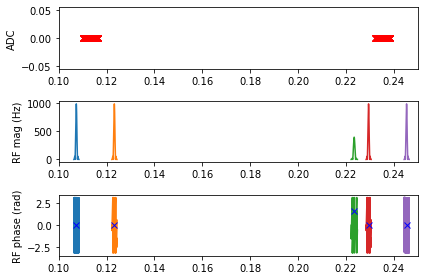

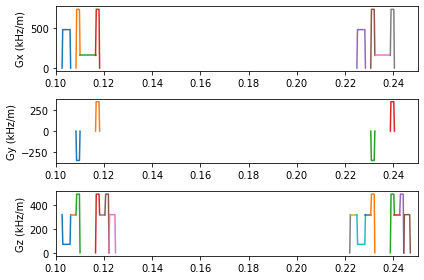

In [7]:
seq.plot(time_range=[0.1, 0.25])

In [ ]:
# In order to localize T2 plane

n_slices = 1
Nx = 128
Ny = 128
fov = 250 * 1e-3
slice_thickness = 6 * 1e-3
rf_flip = 180 # For some reason this value is used for refocusing pulse 
              # And excitation is fixed to 90 deg 
TE = 10 * 1e-3
TR = 1000 * 1e-3
TI = 100 * 1e-3
# Version without flanking spoilers on inversion 
enc='yzx'
seq, __ = irse_interleaved_split_gradient(n_slices=n_slices, Nx=Nx, Ny=Ny, fov=fov, slice_thickness=slice_thickness,
                                          rf_flip=rf_flip, TR=TR, TE=TE, TI=TI, enc=enc, slice_locations=[-0.012])

save_name = f'irse_pypulseq_colab_neg12mm_loc.seq'
seq.write(save_name)  # Generate .seq file
from google.colab import files
files.download(save_name)  # Download locally

Number of slices that can be accommodated =8.0
Number of slices acquired per TR = 1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# For SIMULATION - seq validation paper

n_slices = 1
Nx = 32
Ny = 32
fov = 250 * 1e-3
slice_thickness = 5 * 1e-3
rf_flip = 180 # For some reason this value is used for refocusing pulse 
              # And excitation is fixed to 90 deg 
TE = 12 * 1e-3
TR = 2000 * 1e-3
TI = 100 * 1e-3

# Version without flanking spoilers on inversion 
enc='xyz'
seq, sl_order = irse_interleaved_split_gradient(n_slices=n_slices, Nx=Nx, Ny=Ny, fov=fov, slice_thickness=slice_thickness,
                                          rf_flip=rf_flip, TR=TR, TE=TE, TI=TI, enc=enc, slice_locations=[0])


save_name = f'irse_pypulseq_colab_{Nx}.seq'
seq.write(save_name)  # Generate .seq file

from google.colab import files
files.download(save_name)  # Download locally

print(sl_order)

Number of slices that can be accommodated =16.0
Number of slices acquired per TR = 1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[0]


In [ ]:
# Generate seq for qualitative scan (08/14/20)

# Set default values
n_slices = 30
Nx = 128
Ny = 128
fov = 250 * 1e-3
slice_thickness = 6 * 1e-3
rf_flip = 180 # For some reason this value is used for refocusing pulse 
              # And excitation is fixed to 90 deg 
TE = 12 * 1e-3
TR = 2500 * 1e-3
TI = 50 * 1e-3

sag_enc = 'yzx'
myenc = sag_enc
# Version without flanking spoilers on inversion 
seq_acr, sl_order = irse_interleaved_split_gradient(n_slices=n_slices, Nx=Nx, Ny=Ny, fov=fov, 
                                                    slice_thickness=slice_thickness, rf_flip=rf_flip, 
                                                    TR=TR, TE=TE, TI=TI, enc=myenc)

save_name = f'irse_pypulseq_colab_{n_slices}slices_FOV{fov*1e3}_N{Nx}_TR{TR*1e3}_TE{TE*1e3}_TI{TI*1e3}_thk{slice_thickness*1e3}mm_enc_{myenc}.seq'
seq_acr.write(save_name)  # Generate .seq file
from scipy.io import savemat
savemat(f'Ns{n_slices}_slice_order.mat',{'sl_order': sl_order})
from google.colab import files
files.download(save_name)  # Download locally
files.download(f'Ns{n_slices}_slice_order.mat')

Number of slices that can be accommodated =34.0
Number of slices acquired per TR = 30
[-0.087 -0.081 -0.075 -0.069 -0.063 -0.057 -0.051 -0.045 -0.039 -0.033
 -0.027 -0.021 -0.015 -0.009 -0.003  0.003  0.009  0.015  0.021  0.027
  0.033  0.039  0.045  0.051  0.057  0.063  0.069  0.075  0.081  0.087]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Set default values
n_slices = 2
Nx = 128
Ny = 128
fov = 250 * 1e-3
slice_thickness = 5 * 1e-3
rf_flip = 180 # For some reason this value is used for refocusing pulse 
              # And excitation is fixed to 90 deg 
TE = 80 * 1e-3
TR = 2000 * 1e-3
TI = 100 * 1e-3
seq = irse_interleaved_split_gradient_2(n_slices=n_slices, Nx=Nx, Ny=Ny, fov=fov,
                       slice_thickness=slice_thickness, rf_flip=rf_flip,
                       TR=TR, TE=TE, TI=TI)
"""
elif mode == 'interleaved':
    if params == 'default':  # Override custom parameters in default mode
        n_slices = 4
        Nx = 32
        Ny = 32
        fov = 250 * 1e-3
        slice_thickness = 5 * 1e-3
        rf_flip = 180
        TR = 2000 * 1e-3
        TE = 80 * 1e-3
    seq = se_interleaved(n_slices=n_slices, Nx=Nx, Ny=Ny, fov=fov, 
                         slice_thickness=slice_thickness, rf_flip=rf_flip, 
                         TR=TR, TE=TE)
"""

Number of slices that can be accommodated =6.0
Number of slices acquired per TR = 2


"\nelif mode == 'interleaved':\n    if params == 'default':  # Override custom parameters in default mode\n        n_slices = 4\n        Nx = 32\n        Ny = 32\n        fov = 250 * 1e-3\n        slice_thickness = 5 * 1e-3\n        rf_flip = 180\n        TR = 2000 * 1e-3\n        TE = 80 * 1e-3\n    seq = se_interleaved(n_slices=n_slices, Nx=Nx, Ny=Ny, fov=fov, \n                         slice_thickness=slice_thickness, rf_flip=rf_flip, \n                         TR=TR, TE=TE)\n"

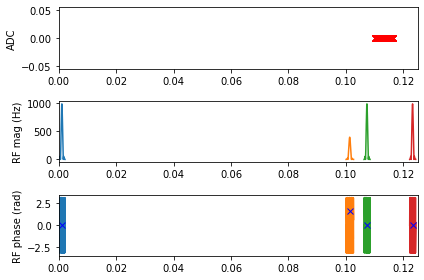

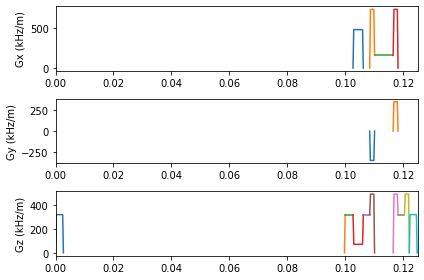

In [ ]:
seq.plot(time_range=(0, TR / 16))

In [ ]:
 seq.write(f'irse_pypulseq_colab.seq')  # Generate .seq file

 from google.colab import files
 files.download(f'irse_pypulseq_colab.seq')  # Download locally

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print(seq.test_report())

Number of blocks: 3200
Number of events:
RF:    768
Gx:   1024
Gy:    512
Gz:   2816
ADC:    256
Delay:    128
Sequence duration: 240.704000 s
TE: 0.080001 s
TR: 0.235690 s
Flip angle: 90.00 180.00 deg
Unique k-space positions (aka cols, rows, etc.): 128 128 
Dimensions: 2
Spatial resolution: 1.97 mm
Spatial resolution: 1.95 mm
Repetitions/slices/contrasts: 2.0
Cartesian encoding trajectory detected
Block timing check passed successfully
Max gradient: 79751 7223 320000 Hz/m == 1.87 0.17 7.52 mT/m
Max slew rate: 258965059 28893905 1280000109 Hz/m/s == 6.08 0.68 30.06 mT/m/s
Max absolute gradient: 320000 Hz/m == 7.52 mT/m
Max absolute slew rate: 1.28e+09 Hz/m/s == 30.06 T/m/s
